In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
        Input, Lambda, Concatenate, Dense, Embedding, Dropout, LSTM, 
        MultiHeadAttention, LayerNormalization, LeakyReLU, GlobalAveragePooling1D, Add
    )
from tensorflow.keras import backend as K


#candles = obj_load("/content/NQ_2")[-100000:]
candles = obj_load("../candle_data/NQ_1")[-40000:]
len(candles)

2025-08-14 08:27:33.605613: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 08:27:33.634566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 08:27:34.194293: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


loading ../candle_data/NQ_1


40000

In [2]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("CUDA version TF was built with:", tf.sysconfig.get_build_info()["cuda_version"])
print("cuDNN version TF was built with:", tf.sysconfig.get_build_info()["cudnn_version"])

TF version: 2.20.0-dev0+selfbuilt
CUDA version TF was built with: 12.8.1
cuDNN version TF was built with: 9


In [3]:
def make_model():
    l = 480
    
    def process_chart_with_time_position(chart_input, name):
        # Extract OHLC and clip values
        ohlc = Lambda(lambda x: tf.clip_by_value(x[:, :, :4], -1000.0, 1000.0),
                      name=f'{name}_clip_ohlc')(chart_input)
        
        # Extract time column and cast to int
        t = Lambda(lambda x: x[:, :, 4:5], name=f'{name}_extract_time')(chart_input)
        t_int = Lambda(lambda x: tf.cast(tf.squeeze(x, axis=-1), tf.int32),
                       name=f'{name}_cast_time')(t)
    
        # Time embedding
        time_embed_layer = Embedding(input_dim=24*60, output_dim=8, name=f'{name}_time_embed')
        t_embed = time_embed_layer(t_int)
    
        # Position embedding (based on sequence length from chart_input shape)
        seq_length = chart_input.shape[1]
        positions = tf.range(seq_length)
        position_embed = Embedding(input_dim=seq_length, output_dim=8,
                                   name=f'{name}_pos_embed')(positions)

        # Add batch dimension so shape matches (batch, seq_length, 8)
        position_embed = tf.expand_dims(position_embed, axis=0)  # (1, 480, 8)
        position_embed = Lambda(lambda x: K.tile(x[0], [K.shape(x[1])[0], 1, 1]))([position_embed, chart_input])
        
        # Combine time and position embeddings
        enhanced_time = Add(name=f'{name}_add_time_pos')([t_embed, position_embed])
    
        # Concatenate OHLC(4) + enhanced_time(8) → 12 dims
        return Concatenate(name=f'{name}_concat')([ohlc, enhanced_time])

    
    def relational_attention_block(x, num_heads=8, key_dim=64, name_prefix=""):
        """Self-attention to capture relationships between candles"""
        # Multi-head self-attention
        attention_out = MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=key_dim,
            name=f'{name_prefix}_attention'
        )(x, x)
        
        # Residual connection + layer norm
        x_normed = LayerNormalization(name=f'{name_prefix}_norm1')(x + attention_out)
        
        # Feed-forward network
        ff_dim = x.shape[-1] * 2
        ff = Dense(ff_dim, activation='gelu', name=f'{name_prefix}_ff1')(x_normed)
        ff = Dense(x.shape[-1], name=f'{name_prefix}_ff2')(ff)
        
        # Second residual connection + layer norm
        output = LayerNormalization(name=f'{name_prefix}_norm2')(x_normed + ff)
        
        return output
    
    def process_timeframe_with_attention(chart_input, pdas_repeated, name):
        """Process each timeframe with attention mechanisms"""
        # Concatenate chart with PDAs
        x = Concatenate(axis=-1, name=f'{name}_concat_pdas')([chart_input, pdas_repeated])
        
        # Initial feature extraction - reduce dimensions gradually
        x = Dense(512, name=f'{name}_dense1')(x)
        x = LayerNormalization(name=f'{name}_norm_init')(x)
        x = LeakyReLU(0.1, name=f'{name}_relu1')(x)
        x = Dropout(0.1, name=f'{name}_dropout1')(x)
        
        x = Dense(256, name=f'{name}_dense2')(x)
        x = LayerNormalization(name=f'{name}_norm2')(x)
        x = LeakyReLU(0.1, name=f'{name}_relu2')(x)
        
        # Apply attention blocks to capture relational patterns
        x = relational_attention_block(x, num_heads=8, key_dim=64, name_prefix=f'{name}_attn1')
        x = relational_attention_block(x, num_heads=8, key_dim=64, name_prefix=f'{name}_attn2')
        x = relational_attention_block(x, num_heads=8, key_dim=64, name_prefix=f'{name}_attn3')
        x = relational_attention_block(x, num_heads=8, key_dim=64, name_prefix=f'{name}_attn4')
        x = relational_attention_block(x, num_heads=8, key_dim=64, name_prefix=f'{name}_attn5')
        x = relational_attention_block(x, num_heads=8, key_dim=64, name_prefix=f'{name}_attn6')
        
        # Final sequence compression with LSTM (single layer is often enough after attention)
        x = LSTM(256, return_sequences=False, name=f'{name}_lstm')(x)
        
        return x
    
    
    ### Inputs
    input_chart_m15 = Input(shape=(l,5), name='chart_m15')
    input_chart_m5  = Input(shape=(l,5), name='chart_m5')
    input_chart_m1  = Input(shape=(l,5), name='chart_m1')
    
    pdas = Input(shape=(3*3 + 3*3 + 1 + 12*5 + 5*3,), name='pdas')
    pdas = Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0), name='clip_pdas')(pdas)
    
    #minutes = Input(shape=(1,), name='minutes')
    
    ### Process each chart with enhanced time/position embeddings
    chart_m15 = process_chart_with_time_position(input_chart_m15, 'm15')
    chart_m5  = process_chart_with_time_position(input_chart_m5, 'm5')
    chart_m1  = process_chart_with_time_position(input_chart_m1, 'm1')
    
    # Repeat PDAs for concatenation
    pdas_repeated = Lambda(
        lambda inputs: tf.repeat(tf.expand_dims(inputs, axis=1), repeats=l, axis=1),
        name='repeat_pdas'
    )(pdas)
    
    ### Process each timeframe with attention
    m15_features = process_timeframe_with_attention(chart_m15, pdas_repeated, 'm15')
    m5_features = process_timeframe_with_attention(chart_m5, pdas_repeated, 'm5') 
    m1_features = process_timeframe_with_attention(chart_m1, pdas_repeated, 'm1')

    ### Final combination and prediction
    # Combine all enhanced features with original PDAs
    c = Concatenate(name='final_concat')([pdas, m1_features, m5_features, m15_features])
    
    # Final prediction layers - smaller than before since attention does heavy lifting
    d = Dense(2048, name='pred_dense1')(c)
    d = LayerNormalization(name='pred_norm1')(d)
    d = LeakyReLU(0.1, name='pred_relu1')(d)
    d = Dropout(0.1, name='pred_dropout1')(d)
    
    d = Dense(1024, name='pred_dense2')(d)
    d = LayerNormalization(name='pred_norm2')(d)
    d = LeakyReLU(0.1, name='pred_relu2')(d)
    d = Dropout(0.1, name='pred_dropout2')(d)
    
    d = Dense(512, name='pred_dense3')(d)
    d = LayerNormalization(name='pred_norm3')(d)
    d = LeakyReLU(0.1, name='pred_relu3')(d)
    
    # Stabilization layer before final prediction
    d = Dense(256, activation='tanh', name='pre_softmax_tanh')(d)
    
    # Final prediction
    output = Dense(3, activation="softmax", dtype="float32", name='output')(d)
    
    model = tf.keras.Model(inputs=[input_chart_m15, input_chart_m5, input_chart_m1, pdas], 
                  outputs=output)
    
    return model

In [4]:
model = make_model()

I0000 00:00:1755160054.867781   26860 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29815 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5090, pci bus id: 0000:01:00.0, compute capability: 12.0
E0000 00:00:1755160055.200179   26948 ptx_compiler_helpers.cc:88] *** WARNING *** Invoking ptxas with version 12.0.140, which corresponds to a CUDA version <=12.6.2. CUDA versions 12.x.y up to and including 12.6.2 miscompile certain edge cases around clamping.
Please upgrade to CUDA 12.6.3 or newer.
2025-08-14 08:27:35.202154: W external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:237] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2025-08-14 08:27:35.202170: W external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:240] Used ptxas at /usr/bin/ptxas
2025-08-14 08:27:35.202232: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile genera

In [5]:
model.load_weights("model.weights.h5")

In [6]:
class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction

In [7]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.m15_candles) == 480):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    #tf.expand_dims(pos_info, 0)
                )

              
                last_action = np.argmax(output)
                #last_action = np.argmax([output[0][0], output[0][1]])
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])

            if(last_action == 2):
                #equity += open_profit
                #current_position = Position(0,0,0,0)
                #print("close position:", open_profit)
                current_order = None

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 2):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    #sl = entry + avg_candle_range * slm
                    sl = sorted_by_low[2][1]
                    tp = entry  -  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, -1)
                        #print("set short order:",entry,sl,tp)
                    if current_position.direction == -1:
                        #current_position.sl = sl
                        current_position.tp = tp



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 2):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    #sl = entry - avg_candle_range * slm
                    sl = sorted_by_high[2][0]
                    tp = entry  +  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, 1)
                        #print("set long order:",entry,sl,tp)
                    if current_position.direction == 1:
                        #current_position.sl = sl
                        current_position.tp = tp

In [8]:
m = MultiTimeframeCandleManager()

#slm = 2
#tpm = 6

slm = 2
tpm = 6


current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np
    ])



for index in tqdm(range(len(candles))):
#for index in tqdm(range(11000)):
    step(index)
    if( index % 100 == 0 ):
        print("\n", equity_L[-1])

print(equity_L[-1])

  0%|          | 0/40000 [00:00<?, ?it/s]


 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0


2025-08-14 08:27:37.930079: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-14 08:27:37.932666: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-14 08:27:37.934300: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-14 08:27:37.935870: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-14 08:27:37.938210: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-14


 160.07187499999782

 95.57187499999782

 266.0718749999978


 18%|█▊        | 7203/40000 [00:10<01:00, 538.51it/s] 


 406.7156249999971

 406.7156249999971


 18%|█▊        | 7369/40000 [00:13<01:28, 369.71it/s]


 406.7156249999971


 19%|█▊        | 7461/40000 [00:15<01:46, 306.50it/s]


 406.7156249999971


 19%|█▉        | 7605/40000 [00:18<02:59, 180.74it/s]


 406.7156249999971


 19%|█▉        | 7706/40000 [00:21<12:55, 41.65it/s] 


 406.7156249999971


 20%|█▉        | 7804/40000 [00:24<15:33, 34.51it/s]


 364.7156249999971


 20%|█▉        | 7906/40000 [00:26<18:17, 29.25it/s]


 367.7156249999971


 20%|██        | 8006/40000 [00:29<10:54, 48.86it/s]


 263.4656249999971


 20%|██        | 8103/40000 [00:32<18:45, 28.35it/s]


 201.7156249999971


 21%|██        | 8204/40000 [00:34<14:30, 36.51it/s]


 37.71562499999709


 21%|██        | 8306/40000 [00:37<15:23, 34.34it/s]


 6.659374999995634


 21%|██        | 8402/40000 [00:39<12:53, 40.83it/s]


 57.159374999995634


 21%|██▏       | 8504/40000 [00:43<16:45, 31.31it/s]


 172.20624999999563


 22%|██▏       | 8609/40000 [00:45<10:09, 51.47it/s]


 172.20624999999563


 22%|██▏       | 8705/40000 [00:47<11:23, 45.81it/s]


 172.20624999999563


 22%|██▏       | 8802/40000 [00:49<13:54, 37.41it/s]


 172.20624999999563


 22%|██▏       | 8904/40000 [00:52<16:51, 30.74it/s]


 172.20624999999563


 23%|██▎       | 9007/40000 [00:55<13:39, 37.80it/s]


 165.95624999999563


 23%|██▎       | 9110/40000 [00:57<10:04, 51.13it/s]


 160.20624999999563


 23%|██▎       | 9206/40000 [00:59<10:11, 50.37it/s]


 127.20624999999563


 23%|██▎       | 9308/40000 [01:02<12:42, 40.26it/s]


 91.45624999999563


 24%|██▎       | 9411/40000 [01:04<09:37, 52.96it/s]


 114.20624999999563


 24%|██▍       | 9508/40000 [01:06<10:59, 46.21it/s]


 198.7562499999949


 24%|██▍       | 9606/40000 [01:09<12:15, 41.31it/s]


 226.7718749999949


 24%|██▍       | 9706/40000 [01:12<13:09, 38.35it/s]


 251.7249999999949


 25%|██▍       | 9803/40000 [01:15<14:43, 34.19it/s]


 60.22499999999491


 25%|██▍       | 9907/40000 [01:18<13:39, 36.73it/s]


 -10.775000000005093


 25%|██▌       | 10006/40000 [01:21<14:10, 35.28it/s]


 -10.775000000005093


 25%|██▌       | 10108/40000 [01:24<14:12, 35.05it/s]


 -10.775000000005093


 26%|██▌       | 10204/40000 [01:27<19:11, 25.86it/s]


 -10.775000000005093


 26%|██▌       | 10307/40000 [01:30<12:07, 40.79it/s]


 -10.775000000005093


 26%|██▌       | 10405/40000 [01:32<12:39, 38.97it/s]


 -10.775000000005093


 26%|██▋       | 10507/40000 [01:35<11:05, 44.29it/s]


 -10.775000000005093


 27%|██▋       | 10605/40000 [01:37<13:00, 37.67it/s]


 -10.775000000005093


 27%|██▋       | 10708/40000 [01:40<10:04, 48.45it/s]


 -10.775000000005093


 27%|██▋       | 10809/40000 [01:42<11:43, 41.50it/s]


 -10.775000000005093


 27%|██▋       | 10905/40000 [01:45<14:55, 32.49it/s]


 -10.775000000005093


 28%|██▊       | 11008/40000 [01:47<10:30, 45.96it/s]


 -10.775000000005093


 28%|██▊       | 11109/40000 [01:49<10:49, 44.49it/s]


 -10.775000000005093


 28%|██▊       | 11206/40000 [01:52<12:59, 36.94it/s]


 -10.775000000005093


 28%|██▊       | 11306/40000 [01:55<09:28, 50.50it/s]


 -10.775000000005093


 29%|██▊       | 11408/40000 [01:57<08:43, 54.63it/s]


 -10.775000000005093


 29%|██▉       | 11506/40000 [01:59<09:45, 48.66it/s]


 -10.775000000005093


 29%|██▉       | 11607/40000 [02:01<10:41, 44.28it/s]


 -10.775000000005093


 29%|██▉       | 11708/40000 [02:04<08:58, 52.49it/s]


 -10.775000000005093


 30%|██▉       | 11803/40000 [02:06<10:57, 42.90it/s]


 -10.775000000005093


 30%|██▉       | 11908/40000 [02:09<11:05, 42.20it/s]


 -0.27500000000509317


 30%|███       | 12007/40000 [02:11<12:58, 35.97it/s]


 43.97499999999491


 30%|███       | 12111/40000 [02:14<09:30, 48.92it/s]


 9.474999999994907


 31%|███       | 12209/40000 [02:16<08:48, 52.59it/s]


 -37.27500000000509


 31%|███       | 12307/40000 [02:18<12:06, 38.10it/s]


 -213.87500000000364


 31%|███       | 12407/40000 [02:21<10:36, 43.34it/s]


 -32.37500000000364


 31%|███▏      | 12510/40000 [02:24<09:26, 48.54it/s]


 20.374999999996362


 32%|███▏      | 12607/40000 [02:26<09:13, 49.53it/s]


 20.374999999996362


 32%|███▏      | 12709/40000 [02:28<11:43, 38.78it/s]


 20.374999999996362


 32%|███▏      | 12809/40000 [02:30<09:59, 45.38it/s]


 20.374999999996362


 32%|███▏      | 12910/40000 [02:33<10:49, 41.71it/s]


 20.374999999996362


 33%|███▎      | 13005/40000 [02:35<12:39, 35.56it/s]


 20.374999999996362


 33%|███▎      | 13106/40000 [02:38<12:43, 35.23it/s]


 20.374999999996362


 33%|███▎      | 13208/40000 [02:41<08:40, 51.52it/s]


 22.374999999996362


 33%|███▎      | 13308/40000 [02:43<09:36, 46.33it/s]


 -15.125000000003638


 34%|███▎      | 13407/40000 [02:45<08:34, 51.66it/s]


 -86.62500000000364


 34%|███▍      | 13509/40000 [02:48<10:22, 42.54it/s]


 -134.87500000000364


 34%|███▍      | 13609/40000 [02:50<07:48, 56.34it/s]


 -177.12500000000364


 34%|███▍      | 13710/40000 [02:52<07:49, 56.04it/s]


 -96.37500000000364


 35%|███▍      | 13806/40000 [02:53<08:55, 48.90it/s]


 26.874999999996362


 35%|███▍      | 13906/40000 [02:56<08:35, 50.66it/s]


 111.69062499999563


 35%|███▌      | 14011/40000 [02:58<09:43, 44.54it/s]


 111.69062499999563


 35%|███▌      | 14105/40000 [03:01<13:49, 31.23it/s]


 111.69062499999563


 36%|███▌      | 14209/40000 [03:03<08:52, 48.48it/s]


 111.69062499999563


 36%|███▌      | 14307/40000 [03:06<13:41, 31.29it/s]


 111.69062499999563


 36%|███▌      | 14406/40000 [03:08<08:45, 48.70it/s]


 111.69062499999563


 36%|███▋      | 14512/40000 [03:10<07:46, 54.68it/s]


 111.69062499999563


 37%|███▋      | 14605/40000 [03:13<12:44, 33.20it/s]


 123.94062499999563


 37%|███▋      | 14705/40000 [03:15<08:09, 51.63it/s]


 146.69062499999563


 37%|███▋      | 14811/40000 [03:17<08:17, 50.64it/s]


 147.69062499999563


 37%|███▋      | 14907/40000 [03:19<08:44, 47.85it/s]


 161.44062499999563


 38%|███▊      | 15006/40000 [03:22<12:16, 33.92it/s]


 65.69062499999563


 38%|███▊      | 15105/40000 [03:24<09:06, 45.57it/s]


 80.0687499999949


 38%|███▊      | 15208/40000 [03:26<08:45, 47.16it/s]


 313.3187499999949


 38%|███▊      | 15309/40000 [03:28<07:58, 51.61it/s]


 319.8187499999949


 39%|███▊      | 15407/40000 [03:31<12:56, 31.65it/s]


 319.8187499999949


 39%|███▉      | 15503/40000 [03:34<12:10, 33.53it/s]


 319.8187499999949


 39%|███▉      | 15607/40000 [03:37<10:07, 40.16it/s]


 319.8187499999949


 39%|███▉      | 15710/40000 [03:39<07:43, 52.36it/s]


 319.8187499999949


 40%|███▉      | 15806/40000 [03:42<13:28, 29.94it/s]


 319.8187499999949


 40%|███▉      | 15905/40000 [03:44<08:43, 45.99it/s]


 327.5687499999949


 40%|████      | 16004/40000 [03:46<07:33, 52.87it/s]


 300.0687499999949


 40%|████      | 16106/40000 [03:49<08:32, 46.62it/s]


 327.3187499999949


 41%|████      | 16204/40000 [03:52<13:13, 29.98it/s]


 321.5687499999949


 41%|████      | 16309/40000 [03:55<09:37, 41.02it/s]


 365.0687499999949


 41%|████      | 16408/40000 [03:57<07:39, 51.38it/s]


 172.62812499999563


 41%|████▏     | 16510/40000 [03:59<07:56, 49.27it/s]


 298.62812499999563


 42%|████▏     | 16604/40000 [04:01<12:54, 30.22it/s]


 187.12812499999563


 42%|████▏     | 16703/40000 [04:04<11:09, 34.82it/s]


 118.62812499999563


 42%|████▏     | 16808/40000 [04:07<09:03, 42.65it/s]


 238.12812499999563


 42%|████▏     | 16908/40000 [04:09<07:31, 51.10it/s]


 174.37812499999563


 43%|████▎     | 17010/40000 [04:11<07:24, 51.75it/s]


 173.37812499999563


 43%|████▎     | 17110/40000 [04:13<06:53, 55.41it/s]


 212.37812499999563


 43%|████▎     | 17206/40000 [04:15<07:07, 53.26it/s]


 295.37812499999563


 43%|████▎     | 17309/40000 [04:17<07:02, 53.76it/s]


 345.1687499999971


 44%|████▎     | 17407/40000 [04:19<08:09, 46.17it/s]


 345.1687499999971


 44%|████▍     | 17508/40000 [04:22<09:19, 40.19it/s]


 345.1687499999971


 44%|████▍     | 17604/40000 [04:25<14:00, 26.64it/s]


 345.1687499999971


 44%|████▍     | 17704/40000 [04:28<13:29, 27.54it/s]


 345.1687499999971


 45%|████▍     | 17807/40000 [04:32<09:16, 39.87it/s]


 438.6687499999971


 45%|████▍     | 17909/40000 [04:34<06:34, 56.04it/s]


 219.4187499999971


 45%|████▌     | 18010/40000 [04:36<07:16, 50.41it/s]


 133.9187499999971


 45%|████▌     | 18104/40000 [04:38<07:58, 45.74it/s]


 80.91874999999709


 46%|████▌     | 18205/40000 [04:41<12:15, 29.65it/s]


 80.91874999999709


 46%|████▌     | 18306/40000 [04:44<10:27, 34.56it/s]


 80.91874999999709


 46%|████▌     | 18404/40000 [04:46<06:21, 56.58it/s]


 80.91874999999709


 46%|████▋     | 18503/40000 [04:48<11:36, 30.87it/s]


 80.91874999999709


 47%|████▋     | 18607/40000 [04:51<08:10, 43.65it/s]


 80.91874999999709


 47%|████▋     | 18712/40000 [04:53<06:19, 56.15it/s]


 80.91874999999709


 47%|████▋     | 18809/40000 [04:55<07:49, 45.10it/s]


 80.91874999999709


 47%|████▋     | 18906/40000 [04:58<06:30, 54.04it/s]


 80.91874999999709


 48%|████▊     | 19010/40000 [05:00<06:20, 55.21it/s]


 80.91874999999709


 48%|████▊     | 19111/40000 [05:02<07:25, 46.84it/s]


 80.91874999999709


 48%|████▊     | 19209/40000 [05:04<06:09, 56.21it/s]


 80.91874999999709


 48%|████▊     | 19312/40000 [05:06<06:56, 49.66it/s]


 80.91874999999709


 49%|████▊     | 19412/40000 [05:08<07:01, 48.87it/s]


 80.91874999999709


 49%|████▉     | 19510/40000 [05:10<07:02, 48.52it/s]


 80.91874999999709


 49%|████▉     | 19607/40000 [05:12<07:55, 42.85it/s]


 80.91874999999709


 49%|████▉     | 19711/40000 [05:14<06:23, 52.87it/s]


 80.91874999999709


 50%|████▉     | 19804/40000 [05:17<08:38, 38.97it/s]


 80.91874999999709


 50%|████▉     | 19909/40000 [05:19<07:06, 47.15it/s]


 80.91874999999709


 50%|█████     | 20010/40000 [05:22<08:29, 39.23it/s]


 80.91874999999709


 50%|█████     | 20104/40000 [05:25<10:18, 32.16it/s]


 80.91874999999709


 51%|█████     | 20205/40000 [05:27<07:48, 42.22it/s]


 80.91874999999709


 51%|█████     | 20303/40000 [05:30<08:23, 39.15it/s]


 80.91874999999709


 51%|█████     | 20407/40000 [05:32<07:03, 46.24it/s]


 80.91874999999709


 51%|█████▏    | 20509/40000 [05:35<07:25, 43.73it/s]


 80.91874999999709


 52%|█████▏    | 20607/40000 [05:37<08:09, 39.60it/s]


 80.91874999999709


 52%|█████▏    | 20708/40000 [05:39<06:32, 49.21it/s]


 80.91874999999709


 52%|█████▏    | 20807/40000 [05:41<06:01, 53.16it/s]


 80.91874999999709


 52%|█████▏    | 20906/40000 [05:44<09:16, 34.32it/s]


 80.91874999999709


 53%|█████▎    | 21005/40000 [05:47<10:50, 29.20it/s]


 80.91874999999709


 53%|█████▎    | 21108/40000 [05:49<06:41, 47.10it/s]


 80.91874999999709


 53%|█████▎    | 21206/40000 [05:51<06:34, 47.59it/s]


 80.91874999999709


 53%|█████▎    | 21308/40000 [05:54<08:41, 35.86it/s]


 80.91874999999709


 54%|█████▎    | 21403/40000 [05:56<07:17, 42.51it/s]


 91.66874999999709


 54%|█████▍    | 21509/40000 [05:59<07:29, 41.11it/s]


 120.91874999999709


 54%|█████▍    | 21606/40000 [06:02<08:19, 36.82it/s]


 149.4187499999971


 54%|█████▍    | 21706/40000 [06:05<09:06, 33.48it/s]


 83.91874999999709


 55%|█████▍    | 21805/40000 [06:07<09:06, 33.31it/s]


 7.16874999999709


 55%|█████▍    | 21910/40000 [06:09<06:21, 47.40it/s]


 -33.58125000000291


 55%|█████▌    | 22004/40000 [06:11<06:52, 43.63it/s]


 -44.33125000000291


 55%|█████▌    | 22108/40000 [06:14<06:37, 45.04it/s]


 -43.33125000000291


 56%|█████▌    | 22212/40000 [06:16<05:13, 56.72it/s]


 -57.08125000000291


 56%|█████▌    | 22303/40000 [06:18<05:20, 55.24it/s]


 -79.58125000000291


 56%|█████▌    | 22410/40000 [06:20<05:59, 48.86it/s]


 -38.08125000000291


 56%|█████▋    | 22510/40000 [06:22<05:18, 54.92it/s]


 32.159374999995634


 57%|█████▋    | 22606/40000 [06:25<06:56, 41.79it/s]


 32.159374999995634


 57%|█████▋    | 22708/40000 [06:27<05:56, 48.44it/s]


 32.159374999995634


 57%|█████▋    | 22810/40000 [06:29<05:37, 50.92it/s]


 28.409374999995634


 57%|█████▋    | 22907/40000 [06:32<06:54, 41.22it/s]


 0.6593749999956344


 58%|█████▊    | 23011/40000 [06:34<05:33, 50.93it/s]


 55.909374999995634


 58%|█████▊    | 23105/40000 [06:37<09:54, 28.40it/s]


 71.90937499999563


 58%|█████▊    | 23207/40000 [06:38<04:51, 57.59it/s]


 71.15937499999563


 58%|█████▊    | 23310/40000 [06:41<05:45, 48.31it/s]


 132.65937499999563


 59%|█████▊    | 23404/40000 [06:43<07:51, 35.17it/s]


 151.40937499999563


 59%|█████▉    | 23504/40000 [06:46<06:46, 40.60it/s]


 146.65937499999563


 59%|█████▉    | 23604/40000 [06:48<05:54, 46.20it/s]


 246.4749999999949


 59%|█████▉    | 23709/40000 [06:51<06:06, 44.45it/s]


 246.4749999999949


 60%|█████▉    | 23803/40000 [06:53<08:01, 33.63it/s]


 246.4749999999949


 60%|█████▉    | 23912/40000 [06:56<05:47, 46.32it/s]


 246.4749999999949


 60%|██████    | 24012/40000 [06:58<05:11, 51.36it/s]


 246.4749999999949


 60%|██████    | 24108/40000 [07:00<05:03, 52.28it/s]


 246.4749999999949


 61%|██████    | 24206/40000 [07:03<06:15, 42.06it/s]


 246.4749999999949


 61%|██████    | 24308/40000 [07:05<06:32, 39.98it/s]


 246.4749999999949


 61%|██████    | 24404/40000 [07:07<06:55, 37.50it/s]


 246.4749999999949


 61%|██████▏   | 24508/40000 [07:10<05:44, 44.91it/s]


 246.4749999999949


 62%|██████▏   | 24610/40000 [07:12<04:44, 54.03it/s]


 246.4749999999949


 62%|██████▏   | 24708/40000 [07:14<04:49, 52.81it/s]


 246.4749999999949


 62%|██████▏   | 24809/40000 [07:16<04:34, 55.31it/s]


 246.4749999999949


 62%|██████▏   | 24910/40000 [07:18<05:18, 47.37it/s]


 246.4749999999949


 63%|██████▎   | 25005/40000 [07:21<08:22, 29.86it/s]


 246.4749999999949


 63%|██████▎   | 25109/40000 [07:24<05:50, 42.50it/s]


 246.4749999999949


 63%|██████▎   | 25205/40000 [07:26<05:38, 43.67it/s]


 246.4749999999949


 63%|██████▎   | 25306/40000 [07:29<05:53, 41.62it/s]


 246.4749999999949


 64%|██████▎   | 25409/40000 [07:31<05:06, 47.59it/s]


 246.4749999999949


 64%|██████▍   | 25506/40000 [07:33<05:23, 44.79it/s]


 246.4749999999949


 64%|██████▍   | 25609/40000 [07:35<05:26, 44.05it/s]


 246.4749999999949


 64%|██████▍   | 25707/40000 [07:38<05:14, 45.48it/s]


 246.4749999999949


 65%|██████▍   | 25809/40000 [07:40<04:18, 54.96it/s]


 246.4749999999949


 65%|██████▍   | 25911/40000 [07:42<04:15, 55.19it/s]


 246.4749999999949


 65%|██████▌   | 26007/40000 [07:44<05:24, 43.18it/s]


 246.4749999999949


 65%|██████▌   | 26109/40000 [07:46<04:19, 53.54it/s]


 246.4749999999949


 66%|██████▌   | 26205/40000 [07:48<07:48, 29.44it/s]


 246.4749999999949


 66%|██████▌   | 26307/40000 [07:51<05:12, 43.84it/s]


 246.4749999999949


 66%|██████▌   | 26405/40000 [07:53<08:52, 25.54it/s]


 246.4749999999949


 66%|██████▋   | 26508/40000 [07:55<04:32, 49.59it/s]


 246.4749999999949


 67%|██████▋   | 26607/40000 [07:58<03:59, 55.92it/s]


 246.4749999999949


 67%|██████▋   | 26705/40000 [08:00<04:31, 48.92it/s]


 246.4749999999949


 67%|██████▋   | 26807/40000 [08:02<04:16, 51.34it/s]


 246.4749999999949


 67%|██████▋   | 26908/40000 [08:04<03:58, 54.92it/s]


 246.4749999999949


 68%|██████▊   | 27012/40000 [08:07<04:09, 52.05it/s]


 246.4749999999949


 68%|██████▊   | 27104/40000 [08:09<07:02, 30.50it/s]


 246.4749999999949


 68%|██████▊   | 27206/40000 [08:12<06:53, 30.97it/s]


 246.4749999999949


 68%|██████▊   | 27310/40000 [08:14<03:43, 56.89it/s]


 246.4749999999949


 69%|██████▊   | 27408/40000 [08:17<04:38, 45.29it/s]


 246.4749999999949


 69%|██████▉   | 27507/40000 [08:19<04:46, 43.63it/s]


 246.4749999999949


 69%|██████▉   | 27607/40000 [08:22<05:34, 37.10it/s]


 246.4749999999949


 69%|██████▉   | 27708/40000 [08:24<04:08, 49.49it/s]


 246.4749999999949


 70%|██████▉   | 27811/40000 [08:26<03:49, 53.06it/s]


 246.4749999999949


 70%|██████▉   | 27908/40000 [08:28<04:39, 43.22it/s]


 246.4749999999949


 70%|███████   | 28004/40000 [08:31<05:05, 39.26it/s]


 246.4749999999949


 70%|███████   | 28107/40000 [08:33<05:03, 39.25it/s]


 246.4749999999949


 71%|███████   | 28208/40000 [08:35<03:49, 51.29it/s]


 246.4749999999949


 71%|███████   | 28309/40000 [08:38<04:19, 44.98it/s]


 236.7249999999949


 71%|███████   | 28408/40000 [08:40<03:26, 56.18it/s]


 276.42187499999636


 71%|███████▏  | 28508/40000 [08:42<04:01, 47.61it/s]


 249.17187499999636


 72%|███████▏  | 28610/40000 [08:45<03:54, 48.55it/s]


 210.92187499999636


 72%|███████▏  | 28710/40000 [08:47<03:33, 52.96it/s]


 227.17187499999636


 72%|███████▏  | 28806/40000 [08:49<04:49, 38.73it/s]


 241.17187499999636


 72%|███████▏  | 28904/40000 [08:51<05:54, 31.34it/s]


 223.67187499999636


 73%|███████▎  | 29012/40000 [08:54<03:20, 54.88it/s]


 239.67187499999636


 73%|███████▎  | 29108/40000 [08:56<03:19, 54.56it/s]


 316.53437499999563


 73%|███████▎  | 29204/40000 [08:58<03:57, 45.41it/s]


 316.53437499999563


 73%|███████▎  | 29308/40000 [09:00<03:20, 53.39it/s]


 316.53437499999563


 74%|███████▎  | 29407/40000 [09:02<04:12, 42.00it/s]


 316.53437499999563


 74%|███████▍  | 29511/40000 [09:04<03:16, 53.45it/s]


 316.53437499999563


 74%|███████▍  | 29606/40000 [09:06<04:43, 36.67it/s]


 316.53437499999563


 74%|███████▍  | 29708/40000 [09:09<03:42, 46.23it/s]


 316.53437499999563


 75%|███████▍  | 29809/40000 [09:11<04:23, 38.73it/s]


 316.53437499999563


 75%|███████▍  | 29909/40000 [09:14<03:55, 42.84it/s]


 316.53437499999563


 75%|███████▌  | 30008/40000 [09:16<03:34, 46.54it/s]


 316.53437499999563


 75%|███████▌  | 30105/40000 [09:18<05:08, 32.09it/s]


 254.03437499999563


 76%|███████▌  | 30208/40000 [09:20<03:12, 50.93it/s]


 237.28437499999563


 76%|███████▌  | 30308/40000 [09:23<03:35, 44.87it/s]


 237.28437499999563


 76%|███████▌  | 30410/40000 [09:25<02:55, 54.53it/s]


 237.28437499999563


 76%|███████▋  | 30510/40000 [09:27<03:11, 49.54it/s]


 237.28437499999563


 77%|███████▋  | 30612/40000 [09:29<02:55, 53.35it/s]


 237.28437499999563


 77%|███████▋  | 30707/40000 [09:31<03:05, 49.99it/s]


 237.28437499999563


 77%|███████▋  | 30808/40000 [09:33<03:15, 46.96it/s]


 237.28437499999563


 77%|███████▋  | 30906/40000 [09:35<03:13, 46.97it/s]


 237.28437499999563


 78%|███████▊  | 31008/40000 [09:37<02:36, 57.52it/s]


 230.03437499999563


 78%|███████▊  | 31109/40000 [09:39<03:07, 47.52it/s]


 208.78437499999563


 78%|███████▊  | 31207/40000 [09:41<03:34, 40.92it/s]


 238.78437499999563


 78%|███████▊  | 31302/40000 [09:43<03:37, 40.03it/s]


 213.53437499999563


 79%|███████▊  | 31407/40000 [09:46<03:47, 37.74it/s]


 130.03437499999563


 79%|███████▉  | 31508/40000 [09:48<02:38, 53.58it/s]


 304.0531249999949


 79%|███████▉  | 31607/40000 [09:51<03:06, 44.98it/s]


 158.8031249999949


 79%|███████▉  | 31708/40000 [09:53<03:06, 44.51it/s]


 158.8031249999949


 80%|███████▉  | 31808/40000 [09:55<02:49, 48.36it/s]


 158.8031249999949


 80%|███████▉  | 31912/40000 [09:58<02:34, 52.34it/s]


 158.8031249999949


 80%|████████  | 32002/40000 [09:59<02:57, 45.03it/s]


 158.8031249999949


 80%|████████  | 32105/40000 [10:02<04:05, 32.19it/s]


 158.8031249999949


 81%|████████  | 32209/40000 [10:04<02:39, 48.81it/s]


 158.8031249999949


 81%|████████  | 32304/40000 [10:06<02:35, 49.48it/s]


 149.0531249999949


 81%|████████  | 32411/40000 [10:09<02:57, 42.68it/s]


 102.8031249999949


 81%|████████▏ | 32508/40000 [10:11<02:55, 42.62it/s]


 74.8031249999949


 82%|████████▏ | 32610/40000 [10:13<02:42, 45.58it/s]


 133.5531249999949


 82%|████████▏ | 32705/40000 [10:16<03:39, 33.18it/s]


 102.5531249999949


 82%|████████▏ | 32808/40000 [10:19<02:23, 50.08it/s]


 61.05312499999491


 82%|████████▏ | 32908/40000 [10:21<02:37, 44.93it/s]


 -24.696875000005093


 83%|████████▎ | 33006/40000 [10:23<02:27, 47.27it/s]


 -78.4468750000051


 83%|████████▎ | 33107/40000 [10:25<02:34, 44.71it/s]


 -78.4468750000051


 83%|████████▎ | 33209/40000 [10:27<02:13, 50.94it/s]


 -78.4468750000051


 83%|████████▎ | 33311/40000 [10:29<02:05, 53.10it/s]


 -78.4468750000051


 84%|████████▎ | 33410/40000 [10:31<02:24, 45.68it/s]


 -78.4468750000051


 84%|████████▍ | 33508/40000 [10:33<02:18, 46.71it/s]


 -78.4468750000051


 84%|████████▍ | 33609/40000 [10:35<01:59, 53.30it/s]


 -39.94687500000509


 84%|████████▍ | 33710/40000 [10:37<01:54, 55.07it/s]


 -64.6968750000051


 85%|████████▍ | 33811/40000 [10:39<02:13, 46.47it/s]


 -49.94687500000509


 85%|████████▍ | 33907/40000 [10:41<02:11, 46.46it/s]


 -81.6968750000051


 85%|████████▌ | 34002/40000 [10:44<02:01, 49.30it/s]


 -114.6968750000051


 85%|████████▌ | 34108/40000 [10:46<02:18, 42.53it/s]


 -99.4468750000051


 86%|████████▌ | 34207/40000 [10:49<01:49, 52.73it/s]


 -41.94687500000509


 86%|████████▌ | 34307/40000 [10:51<02:03, 46.20it/s]


 57.30312499999491


 86%|████████▌ | 34409/40000 [10:52<01:44, 53.68it/s]


 164.5531249999949


 86%|████████▋ | 34510/40000 [10:55<01:41, 53.95it/s]


 236.42499999999563


 87%|████████▋ | 34612/40000 [10:57<01:44, 51.60it/s]


 236.42499999999563


 87%|████████▋ | 34704/40000 [10:59<02:46, 31.75it/s]


 236.42499999999563


 87%|████████▋ | 34804/40000 [11:02<02:09, 40.22it/s]


 236.42499999999563


 87%|████████▋ | 34909/40000 [11:05<01:44, 48.80it/s]


 236.42499999999563


 88%|████████▊ | 35003/40000 [11:07<02:19, 35.81it/s]


 267.17499999999563


 88%|████████▊ | 35105/40000 [11:10<02:07, 38.29it/s]


 325.42499999999563


 88%|████████▊ | 35205/40000 [11:12<01:57, 40.88it/s]


 355.67499999999563


 88%|████████▊ | 35308/40000 [11:15<01:25, 54.88it/s]


 262.42499999999563


 89%|████████▊ | 35407/40000 [11:17<01:32, 49.59it/s]


 239.42499999999563


 89%|████████▉ | 35506/40000 [11:19<01:45, 42.52it/s]


 118.67499999999563


 89%|████████▉ | 35610/40000 [11:22<01:28, 49.50it/s]


 86.92499999999563


 89%|████████▉ | 35706/40000 [11:23<01:23, 51.45it/s]


 81.92499999999563


 90%|████████▉ | 35808/40000 [11:25<01:27, 47.97it/s]


 134.26874999999563


 90%|████████▉ | 35904/40000 [11:27<01:48, 37.90it/s]


 134.26874999999563


 90%|█████████ | 36008/40000 [11:30<01:30, 43.88it/s]


 134.26874999999563


 90%|█████████ | 36107/40000 [11:32<01:19, 48.78it/s]


 134.26874999999563


 91%|█████████ | 36207/40000 [11:34<01:09, 54.57it/s]


 134.26874999999563


 91%|█████████ | 36309/40000 [11:36<01:17, 47.80it/s]


 134.26874999999563


 91%|█████████ | 36408/40000 [11:38<01:05, 55.03it/s]


 134.26874999999563


 91%|█████████▏| 36506/40000 [11:41<01:55, 30.26it/s]


 134.26874999999563


 92%|█████████▏| 36606/40000 [11:43<01:20, 42.39it/s]


 134.26874999999563


 92%|█████████▏| 36707/40000 [11:45<01:18, 42.06it/s]


 134.26874999999563


 92%|█████████▏| 36807/40000 [11:48<01:09, 45.76it/s]


 134.26874999999563


 92%|█████████▏| 36911/40000 [11:50<00:58, 52.47it/s]


 134.26874999999563


 93%|█████████▎| 37005/40000 [11:53<01:36, 31.10it/s]


 134.26874999999563


 93%|█████████▎| 37106/40000 [11:56<01:25, 33.96it/s]


 134.26874999999563


 93%|█████████▎| 37206/40000 [11:58<01:01, 45.22it/s]


 134.26874999999563


 93%|█████████▎| 37306/40000 [12:01<01:07, 39.74it/s]


 134.26874999999563


 94%|█████████▎| 37410/40000 [12:03<00:49, 51.95it/s]


 134.26874999999563


 94%|█████████▍| 37508/40000 [12:05<00:54, 45.40it/s]


 134.26874999999563


 94%|█████████▍| 37604/40000 [12:08<01:24, 28.24it/s]


 134.26874999999563


 94%|█████████▍| 37709/40000 [12:11<00:57, 40.15it/s]


 118.26874999999563


 95%|█████████▍| 37804/40000 [12:13<01:15, 29.28it/s]


 77.01874999999563


 95%|█████████▍| 37905/40000 [12:16<00:52, 40.26it/s]


 95.76874999999563


 95%|█████████▌| 38006/40000 [12:18<00:44, 44.65it/s]


 -13.731250000004366


 95%|█████████▌| 38106/40000 [12:20<00:52, 36.29it/s]


 -119.73125000000437


 96%|█████████▌| 38205/40000 [12:23<00:40, 44.25it/s]


 -194.48125000000437


 96%|█████████▌| 38307/40000 [12:25<00:35, 48.23it/s]


 -262.48125000000437


 96%|█████████▌| 38410/40000 [12:27<00:29, 54.63it/s]


 -164.48125000000437


 96%|█████████▋| 38510/40000 [12:30<00:28, 52.91it/s]


 -300.48125000000437


 97%|█████████▋| 38605/40000 [12:32<00:32, 43.00it/s]


 -404.98125000000437


 97%|█████████▋| 38703/40000 [12:35<00:46, 27.92it/s]


 -404.98125000000437


 97%|█████████▋| 38808/40000 [12:37<00:23, 51.54it/s]


 -404.98125000000437


 97%|█████████▋| 38907/40000 [12:40<00:29, 37.23it/s]


 -404.98125000000437


 98%|█████████▊| 39008/40000 [12:43<00:27, 36.48it/s]


 -404.98125000000437


 98%|█████████▊| 39109/40000 [12:45<00:18, 48.36it/s]


 -340.98125000000437


 98%|█████████▊| 39207/40000 [12:48<00:25, 31.69it/s]


 -296.73125000000437


 98%|█████████▊| 39308/40000 [12:50<00:12, 54.04it/s]


 -308.48125000000437


 99%|█████████▊| 39410/40000 [12:52<00:10, 56.35it/s]


 -434.48125000000437


 99%|█████████▉| 39512/40000 [12:54<00:08, 54.51it/s]


 -455.98125000000437


 99%|█████████▉| 39608/40000 [12:56<00:06, 57.47it/s]


 -391.23125000000437


 99%|█████████▉| 39708/40000 [12:58<00:06, 46.42it/s]


 -74.48125000000437


100%|█████████▉| 39809/40000 [13:00<00:04, 47.17it/s]


 -315.23125000000437


100%|█████████▉| 39907/40000 [13:02<00:01, 50.21it/s]


 -315.23125000000437


100%|██████████| 40000/40000 [13:04<00:00, 50.99it/s]

-315.23125000000437


0 -315.23125000000437


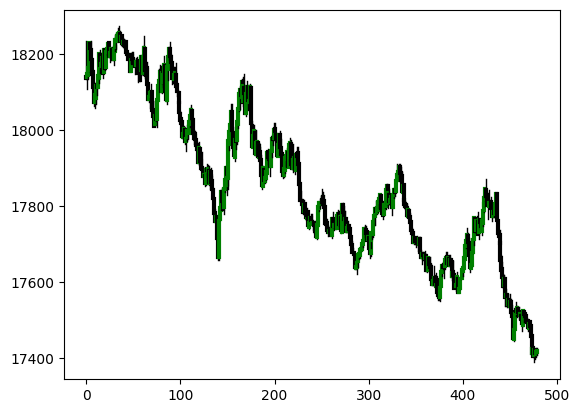

In [9]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
#step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
    plt.axhline(current_position.tp, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
    plt.axhline(current_order.tp, color = "orange")
print(current_position.direction, equity_L[-1])

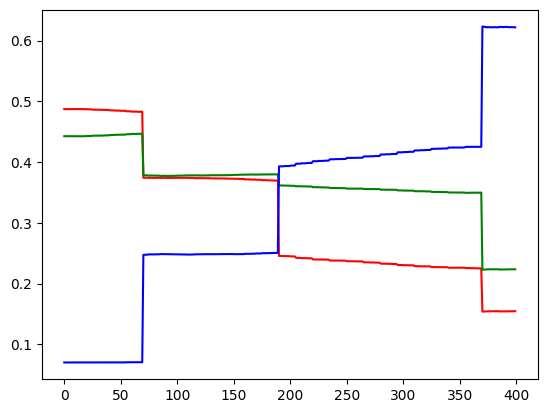

In [10]:
#plt.plot(outputs)
plt.plot([x[0] for x in outputs[-400:]], color="r")
plt.plot([x[1] for x in outputs[-400:]], color="g")
plt.plot([x[2] for x in outputs[-400:]], color="b")

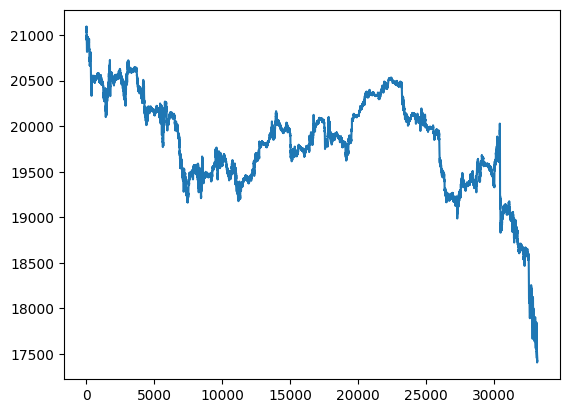

In [11]:
plt.plot([x.c for x in all_candles])


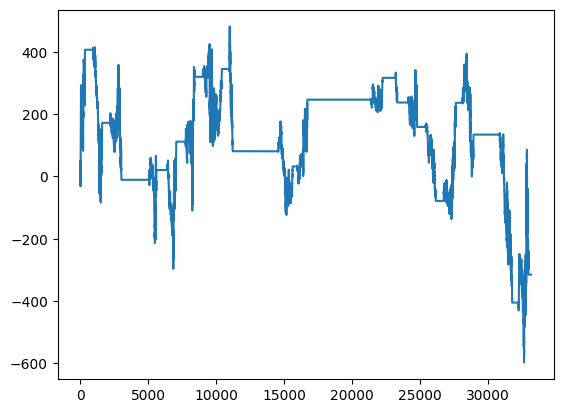

In [12]:
plt.plot(equity_L)


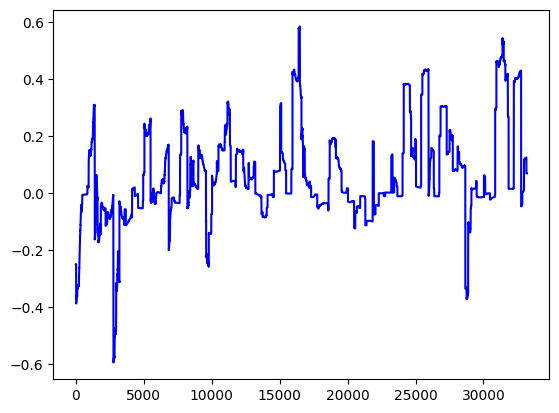

In [13]:
plt.plot([x[1]-x[0] for x in outputs], color="b")